In [9]:
import h5py
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader, Subset
import torch.optim as optim

In [10]:
# CONFIG

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 32
NUM_WORKERS = 4
PATH = "/content/drive/MyDrive/gsoc/quark-gluon_data-set_n139306.hdf5"

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [12]:
class HDF5Dataset(Dataset):
    def __init__(self, file_path):
        self.file = h5py.File(file_path, 'r')
        self.data = self.file['X_jets']
        self.m0 = self.file['m0']
        self.pt = self.file['pt']
        self.y = self.file['y']

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx):
        # Load X_jets in shape (125, 125, 3) from HDF5 file
        x_jets = self.data[idx]
        # Transpose the array to shape (3, 125, 125)
        x_jets = torch.tensor(x_jets.transpose(2, 0, 1)).detach().clone()
        return x_jets

In [13]:
dataset = HDF5Dataset(PATH)

In [14]:
import torch.utils.data as data_utils

indices = torch.arange(1000)
train_dataset = Subset(dataset, indices)

In [15]:
example_data = dataset.__getitem__(0)

In [16]:
example_data.shape

torch.Size([3, 125, 125])

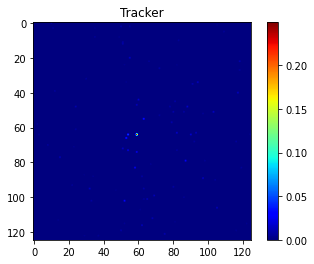

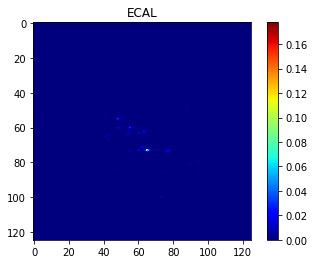

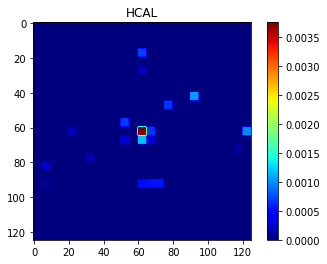

In [17]:
plt.imshow(example_data[0], cmap='jet')
plt.title('Tracker')
plt.colorbar()
plt.show()

plt.imshow(example_data[1], cmap='jet')
plt.title('ECAL')
plt.colorbar()
plt.show()

plt.imshow(example_data[2], cmap='jet')
plt.title('HCAL')
plt.colorbar()
plt.show()

In [18]:
from tqdm import tqdm

In [19]:
# # Calculate min and max for each dataset
# tracker_min, tracker_max = torch.finfo(torch.float32).max, torch.finfo(torch.float32).min
# ecal_min, ecal_max = torch.finfo(torch.float32).max, torch.finfo(torch.float32).min
# hcal_min, hcal_max = torch.finfo(torch.float32).max, torch.finfo(torch.float32).min

# for data in tqdm(train_dataloader):
#     tracker = data[0]
#     ecal = data[1]
#     hcal = data[2]

#     # Update min and max for each dataset
#     tracker_min = min(tracker_min, tracker.min())
#     tracker_max = max(tracker_max, tracker.max())
#     ecal_min = min(ecal_min, ecal.min())
#     ecal_max = max(ecal_max, ecal.max())
#     hcal_min = min(hcal_min, hcal.min())
#     hcal_max = max(hcal_max, hcal.max())

# # Create scalers
# tracker_scaler = (tracker_min, tracker_max)
# ecal_scaler = (ecal_min, ecal_max)
# hcal_scaler = (hcal_min, hcal_max)

tracker_scaler = (0.0, 1.1015)
ecal_scaler = (0.0, 2.0581)
hcal_scaler = (0.0, 0.9226)



In [20]:
# organizing by channel
data_scale = {0: tracker_scaler, 1: ecal_scaler, 2: hcal_scaler}
data_scale

{0: (0.0, 1.1015), 1: (0.0, 2.0581), 2: (0.0, 0.9226)}

In [21]:
def min_max_scaler(data, data_scale, new_scale=(0,1)):
    new_min, new_max = new_scale
    data = data.clone()
    
    # iterate through each channel, scaling according to its (min, max)
    for channel in data_scale:
        data_min, data_max = data_scale[channel]

        channel_data = data[:, channel]

        data_std = (channel_data - data_min) / (data_max - data_min)
        data_scaled = data_std * (new_max - new_min) + new_min

        data[:, channel] = data_scaled
    
    return data

In [22]:
import numpy as np

In [23]:
train_size = 0.8

val_dataset = train_dataset
test_dataset = train_dataset

num_train = len(train_dataset)
indices = list(range(num_train))
split = int(np.floor(train_size * num_train))
split2 = int(np.floor((train_size+(1-train_size)/2) * num_train))
np.random.shuffle(indices)
train_idx, valid_idx, test_idx = indices[:split], indices[split:split2], indices[split2:]

train_data = Subset(train_dataset, indices=train_idx)
val_data = Subset(val_dataset, indices=valid_idx)
test_data = Subset(test_dataset, indices=test_idx)

train_data = Subset(train_dataset, indices=train_idx)
val_data = Subset(val_dataset, indices=valid_idx)
test_data = Subset(test_dataset, indices=test_idx)

In [24]:
train_dataloader = DataLoader(train_data, shuffle=True, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)
val_dataloader = DataLoader(train_data, shuffle=True, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)

/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [25]:
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(1, 16, 7, stride=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 7, stride=3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 7)
        self.flat = nn.Flatten()
        self.mu = nn.Linear(3136, 512)
        self.var = nn.Linear(3136, 512)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = self.flat(x)
        mu = self.mu(x)
        var = self.var(x)

        return mu, var

class Decoder(nn.Module):
    def __init__(self):
        super().__init__()

        self.linear = nn.Linear(512, 3136)
        self.conv4 = nn.ConvTranspose2d(64, 32, 7)
        self.conv5 = nn.ConvTranspose2d(32, 16, 7, stride=3, padding=1)
        self.conv6 = nn.ConvTranspose2d(16, 1, 6, stride=3, padding=1, output_padding=1)

    def forward(self, x):
        x = self.linear(x)
        x = x.reshape(-1, 64, 7, 7)
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x))
        x = torch.sigmoid(self.conv6(x)) # input scaled between 0 and 1, so output has to be bounded as well

        return x
    
class VAE(nn.Module):

    def __init__(self, encoder, decoder):
        super().__init__()

        self.encoder = encoder
        self.decoder = decoder

    def forward(self, x):
        
        mu, var = self.encoder(x)
        std = torch.exp(var / 2)
        eps = torch.randn_like(std)
        x_sample = eps.mul(std).add_(mu)
        x = self.decoder(x_sample)
        
        return x, mu, var

In [26]:
def display_images(input_image, output_image, display=1):
    titles = ['Tracker', 'ECAL', 'HCAL']
    
    for d in range(display):
        # plot input images
        input_image_numpy = input_image.detach().cpu().numpy()
        plt.figure(figsize=(18,6))
        plt.suptitle('Original images // Reconstructed images', fontsize=20)

        # plot 4 images
        for i in range(len(titles)):
            plt.subplot(1, 3, i+1)
            
            plt.imshow(input_image_numpy[i+4*d][i], cmap='jet', vmin=0, vmax=0.01)
            plt.colorbar()
            plt.title(titles[i])
            plt.axis(False)

        plt.show()
                
        # plot output images
        output_image_numpy = output_image.detach().cpu().numpy()
        plt.figure(figsize=(18,6))

        # plot 4 images
        for i in range(len(titles)):
            plt.subplot(1, 3, i+1)
            
            plt.imshow(output_image_numpy[i+4*d][i], cmap='jet', vmin=0, vmax=0.01)
            plt.colorbar()
            plt.title(titles[i])
            plt.axis(False)
            
        plt.show()

In [27]:
def vae_loss(pred, true, mu, var):
    rec = F.binary_cross_entropy(pred, true, reduction='sum') # reconstruction
    #rec = F.mse_loss(pred, true, reduction='sum') # reconstruction
    kl = -0.5 * torch.mean(1 + var - mu.pow(2) - var.exp()) # KL

    return rec + kl

In [28]:
def evaluate(model, dataloader, data_scale, display=0):
    # set network to evaluation mode
    model.eval()
    
    criterion = vae_loss
    running_loss = 0.0
    
    with torch.no_grad():
        for data in dataloader:
            data = data.to(DEVICE)
            data = min_max_scaler(data, data_scale)
            
            if display:
                outputs_list = [] # used for displaying reconstructed images
            
            for channel in data_scale:
                # unsqueeze to generate 1 channel axis
                data_channel = data[:, channel].unsqueeze(1)
            
                # predict
                outputs, mu, var = model(data_channel)
                running_loss += criterion(outputs, data_channel, mu, var).item()
                
                if display:
                    outputs_list.append(outputs)
            
        # get loss over whole dataset
        loss = running_loss / len(dataloader)
        
        # display images
        if display:
            # concatenate Tracker, ECAL, HCAL images
            outputs_list = torch.cat(outputs_list, dim=1)
            display_images(data, outputs_list, display)
            
    return loss
    

def train(model, train_dataloader, val_dataloader, data_scale, epochs):
    # hyperparameters and optimizer
    criterion = vae_loss
    lr = 1e-3
    
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
    
    # early stopping variables
    best_loss = np.inf # ideal loss == 0
    patience = 5 # stops training if loss doesn't improve in 5 epochs
    bad_epochs = 0
    
    # metrics
    history = {'train_loss': [], 'val_loss': []}
    
    # train
    for epoch in range(epochs):
        # set network to training mode
        encoder.train()
        decoder.train()

        running_loss = 0.0

        for data in train_dataloader:
            data = data.to(DEVICE)
            data = min_max_scaler(data, data_scale)
            
            outputs_list = [] # used for displaying reconstructed images

            # we'll be iterating over each channel in order to update the VAE weights
            # for each Tracker, ECAL, HCAL image inside `data`
            for channel in data_scale:
                # unsqueeze to generate 1 channel axis
                data_channel = data[:, channel].unsqueeze(1)
                
                # zero gradients
                optimizer.zero_grad()

                # encode/decode ang get loss
                outputs, mu, var = model(data_channel)
                loss = criterion(outputs, data_channel, mu, var)

                # backpropagate and update weights
                loss.backward()
                optimizer.step()

                # metrics
                running_loss += loss.item()
                
                outputs_list.append(outputs)

        # get metrics
        epoch_loss = running_loss / len(train_dataloader)
        history['train_loss'].append(epoch_loss)
        
        # lr scheduler
        scheduler.step()
        
        # display reconstruction for training data
        outputs_list = torch.cat(outputs_list, dim=1) # concatenate Tracker, ECAL, HCAL images
        display_images(data, outputs_list)

        # evaluate on validation data
        val_epoch_loss = evaluate(model, val_dataloader, data_scale)
        history['val_loss'].append(val_epoch_loss)

        print('[Epoch {}/{}] loss: {:.6f}; val loss: {:.6f};'.format(epoch+1, epochs, epoch_loss, val_epoch_loss))
        
        # save checkpoint
        if val_epoch_loss < best_loss:
            torch.save({'encoder_weights': encoder.state_dict(),
                        'decoder_weights': decoder.state_dict()}, './model_task2.pt')
            best_loss = val_epoch_loss
            bad_epochs = 0

        else:
            bad_epochs += 1

        if bad_epochs >= patience:
            print(f"reached {bad_epochs} bad epochs, stopping training with best val loss of {best_loss}!")
            break

    best = torch.load('./model_task2.pt')
    encoder.load_state_dict(best['encoder_weights'])
    decoder.load_state_dict(best['decoder_weights'])

    return encoder, decoder, history

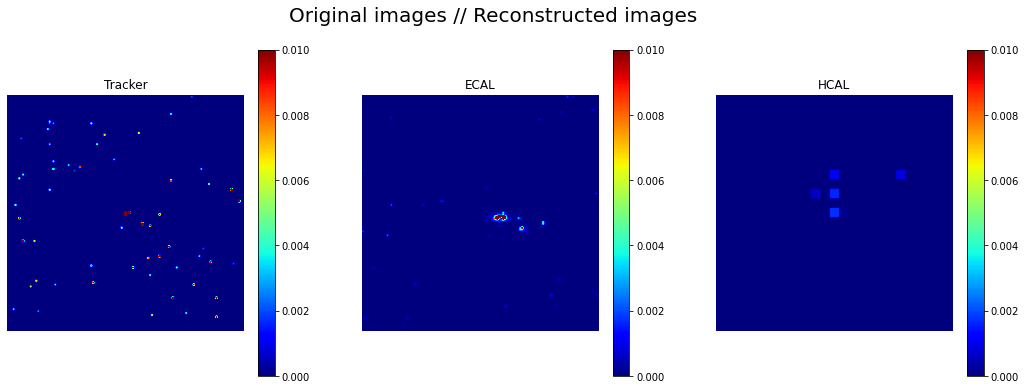

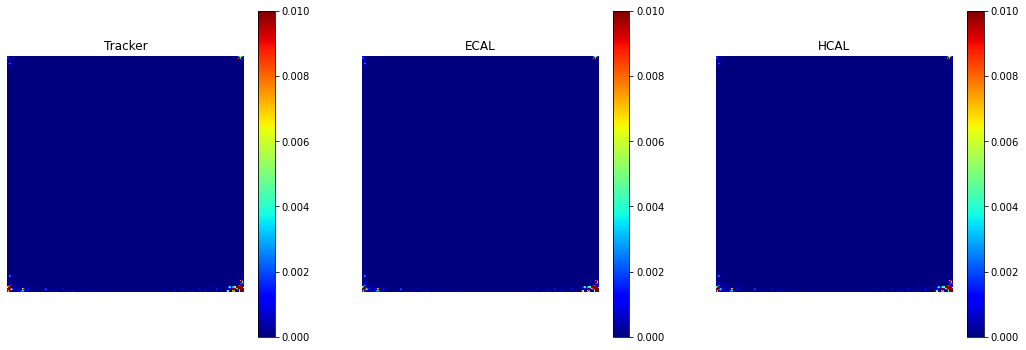

[Epoch 1/20] loss: 95999.114453; val loss: 6486.943467;


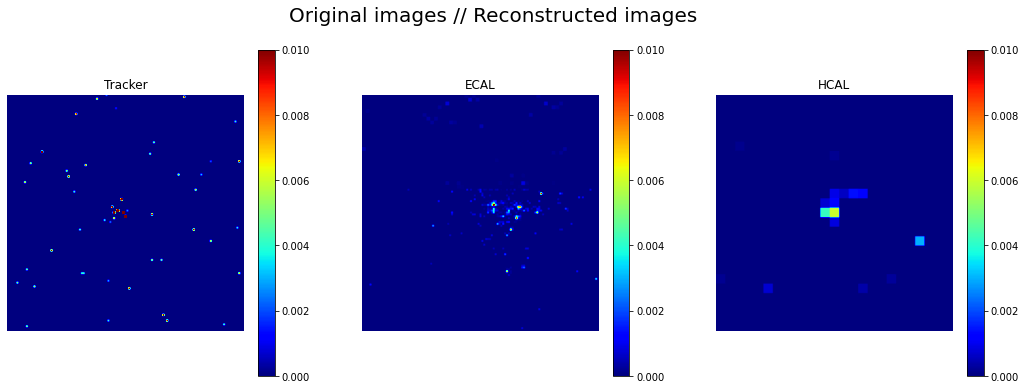

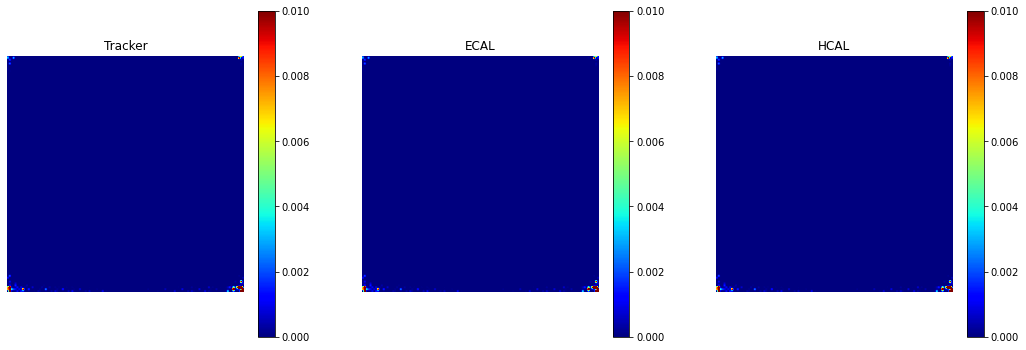

In [ ]:
encoder = Encoder()
encoder = encoder.to(DEVICE)

decoder = Decoder()
decoder = decoder.to(DEVICE)

vae = VAE(encoder, decoder)
vae = vae.to(DEVICE)

encoder, decoder, history = train(vae, train_dataloader, val_dataloader, data_scale, epochs=20)